# Reconhecimento de objetos em imagens com Redes Neurais Convolucionais

## CIFAR-10

## Objetivo

Este Notebook constrói, treina e aplica uma Rede Neural Convolucional para classificar objetos em imagens (fotografias), considerando as 10 categorias abaixo:

0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship

9: truck

## Conjuto de dados (*Datasets*)

CIFAR é uma sigla do [Canadian Institute For Advanced Research](https://www.cs.toronto.edu/~kriz/cifar.html). O conjunto de dados [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10) foi desenvolvido junto com o conjunto de dados CIFAR-100 por pesquisadores do instituto CIFAR para pesquisas de visão computacional.

É um conjunto de dados bem conhecido e amplamente utilizado para benchmarking de algoritmos de visão computacional no campo do aprendizado de máquina.

As imagens desse dataset são pequenas, muito menores do que uma fotografia comum.

CIFAR-10 é um subconjunto rotulado do conjunto de dados de [80 milhões de pequenas imagens](https://en.wikipedia.org/wiki/80_Million_Tiny_Images).

* #### **Dados de treino**: 50.000 imagens 
Utilizado para criar o modelo preditivo/classificador

* #### **Dados de teste**: 10.000 imagens 
Utilizado para avaliar o modelo durante o treinamento

* #### Imagens quadradas coloridas (com 3 canais) de 32 × 32 pixels

* #### Há 6.000 imagens de cada uma das 10 classes

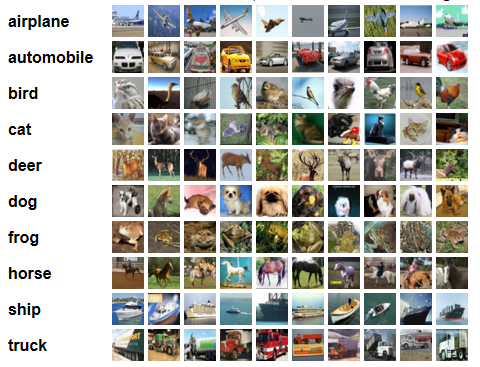

## Habilitando GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Carregando os dados

In [2]:
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(trainX, trainY), (testX, testY) = cifar10.load_data()
print('Dados de treino: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Dados de teste: X=%s, y=%s' % (testX.shape, testY.shape))

170508288/170498071 [==============================] - 2s 0us/step
Dados de treino: X=(50000, 32, 32, 3), y=(50000, 1)
Dados de teste: X=(10000, 32, 32, 3), y=(10000, 1)


Abaixo seguem visualizações de algumas imagens do conjunto de dados de treinamento.

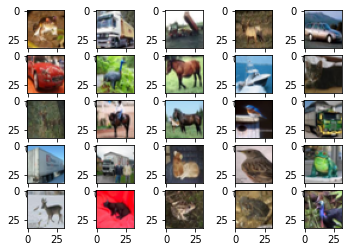

In [3]:
from matplotlib import pyplot
for i in range(25):
	# define subplot
	pyplot.subplot(5,5,i+1)
	# imprime os dados (imagens) 
	pyplot.imshow(trainX[i])
# mostra a figura
pyplot.show()

## Normalizando os dados

Sabemos que os valores de pixel para cada imagem no conjunto de dados são inteiros sem sinal no intervalo entre preto e branco, ou 0 e 255 (em cada um dos 3 canais).

Normalizamos então os valores para o intervalo [0,1]. Isso envolve primeiro a conversão do tipo de dados de inteiros sem sinal em flutuantes e, em seguida, a divisão dos valores de pixel pelo valor máximo.

In [4]:
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

## *OneHotEncoder*

Sabemos que são 10 classes (rótulos) e que as classes são representadas como inteiros únicos.

Podemos então usar uma codificação para a classe de cada amostra, transformando o inteiro em um vetor binário de 10 elementos com 1 para o índice do valor da classe e 0 valores para todas as outras classes. Podemos fazer isso com a função to_categorical().

In [5]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)

## Construção da Rede Neural Convolucional

Utilizamos o modelo sequencial oferecido pelo Keras para montarmos as camadas de nossa rede neural convolucional. Lembrando que o Keras utiliza o TensorFlow como backend. Na verdade, o Keras é apenas uma biblioteca para simplificar a complexidade do TensorFlow.

A arquitetura aqui apresentada segue o modelo **VGG** por ser fácil de entender e implementar, e principalmente pelo seu ótimo desempenho na competição [ILSVRC 2014](http://www.image-net.org/challenges/LSVRC/2014/results#clsloc).

A arquitetura consiste no empilhamento de camadas convolucionais com pequenos filtros 3 × 3 seguidos por uma camada de *max pooling*. Juntas, essas camadas formam um bloco, e esses blocos podem ser repetidos onde o número de filtros em cada bloco é aumentado com a profundidade da rede, como 32, 64, 128, 256 para os primeiros quatro blocos do modelo. *Padding* é usado nas camadas convolucionais para garantir que a altura e a largura dos mapas de recursos de saída correspondam às entradas.

Dado que o problema é uma tarefa de classificação multiclasse, teremos então uma **camada de saída com 10 nós** para prever a distribuição de probabilidade de uma imagem pertencente a cada uma das 10 classes. Isso também requer a **função de ativação softmax**.

Todas as outras camadas usarão a **função de ativação ReLU** e a estratégia de **inicialização de pesos He** (melhores recomendações para esses parâmetros).

Entre a camada de extração de atributos (camada de convolução)e a camada de saída, utiliza-se uma camada densa (**full conection**) para interpretar os atributos/características, neste caso com 128 nós.

Características particulares dessa versão:
 
* **03 blocos VGG**: 02 camadas convolucionais com 32 filtros de tamanho 3x3 seguido por uma camada de pooling (máximo), 02 camadas convolucionais com 64 filtros de tamanho 3x3 seguido por uma camada de pooling (máximo) e mais 02 camadas convolucionais com 128 filtros de tamanho 3x3 seguido por uma camada de pooling (máximo)
* **Data Augmentation**: realiza transformações no conjunto de dados de treinamento com pequenas modificações aleatórias. Isso tem um efeito de regularização, pois expande o conjunto de dados de treinamento e permite que o modelo aprenda os mesmos recursos gerais, embora de uma maneira mais generalizada. Isso pode ser implementado no Keras usando a classe "ImageDataGenerator".
https://keras.io/api/preprocessing/image/#imagedatagenerator-class

                                       

In [6]:
# Importação dos pacotes
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Inicializando a Rede Neural Convolucional
model = Sequential()
# 03 blocos VGG
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
# Flattening (para converter a estrutura de dados da camada anterior em um vetor)
model.add(Flatten())
# Camada Full connection (128 neurônios com função de ativação Relu e inicialização de pesos HE)
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# Camada de saída com 10 neurônios (10 classes!) e função de ativação softmax (multiclasse)
model.add(Dense(10, activation='softmax'))

### Sumário da arquitetura da rede neural convolucional

Execute o comando abaixo para obter um resumo da arquitetura da rede neural convolucional construída e para ver também o número de parâmetros da mesma.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

Compilação da Rede Neural Convolucional

Esta versão utiliza uma configuração conservadora para o otimizador: **gradiente estocástico com uma taxa de aprendizado de 0,001 e um momentum de 0,9**.

A função de perda (função de erro): **entropia cruzada categórica** adequada para classificação multiclasse

E a métrica de desempenho 'accuracy' (proporção de casos corretamente previstos).

In [9]:
from tensorflow.keras.optimizers import SGD
# Compilando a rede
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Data augmentation

Isso pode ser implementado no Keras usando a classe "ImageDataGenerator".

Cria-se uma instância da classe ImageDataGenerator.

Um objeto iterador pode ser criado para o conjunto de imagens de treinamento carregada na memória utilizando a função **flow()**.

O iterador retornará um lote de imagens alteradas (augmented images) para cada iteração.

As imagens no conjunto de dados não são usadas diretamente. Em vez disso, apenas imagens aumentadas são fornecidas ao modelo. Como os aumentos são realizados aleatoriamente, isso permite que imagens modificadas e muito próximas das imagens originais (quase nenhuma modificação) sejam geradas e usadas ​​durante o treinamento.

Dado que o conjunto de dados é composto por pequenas fotos de objetos, não queremos usar um aumento que distorça muito as imagens, para que recursos úteis nas imagens possam ser preservados e usados.

Nós analisaremos o efeito de um “augmentation” simples sobre as imagens base, especificamente flips horizontais e 10% de shifts na altura e largura da imagem.


In [10]:
from keras.preprocessing.image import ImageDataGenerator
# cria o gerador de dados (instância da classe ImageDataGenerator)
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# cria objeto (iterador) para o conjunto de imagens de treinamento carregada na memória utilizando a função flow()
it_train = datagen.flow(trainX, trainY, batch_size=64)

## Treinamento da Rede Neural Convolucional
Uma vez que o objeto iterador é criado ele pode ser usado para treinar a rede neural via função **fit_generator()**.

O argumento *steps_per_epoch* deve especificar o número de lotes de amostras compreendendo uma época. Por exemplo, nessa aplicação o conjunto de dados de treinamento possui 50.000 imagens e o *batch_size* é igual a 64, então o valor para o argumento *steps_per_epoch* quando treinamos (fit) o classificador sobre o conjunto de dados alterado (augmentated) pode ser int(50000/64), ou 781 batches.

In [11]:
history = model.fit(it_train, steps_per_epoch=int(trainX.shape[0] / 64), epochs=100, validation_data=(testX, testY))

Epoch 1/100
781/781 [==============================] - 37s 32ms/step - loss: 1.7770 - accuracy: 0.3509 - val_loss: 1.5409 - val_accuracy: 0.4468
Epoch 2/100
781/781 [==============================] - 26s 33ms/step - loss: 1.4764 - accuracy: 0.4642 - val_loss: 1.3625 - val_accuracy: 0.5141
Epoch 3/100
781/781 [==============================] - 25s 31ms/step - loss: 1.3426 - accuracy: 0.5193 - val_loss: 1.2163 - val_accuracy: 0.5660
Epoch 4/100
781/781 [==============================] - 24s 31ms/step - loss: 1.2412 - accuracy: 0.5576 - val_loss: 1.1237 - val_accuracy: 0.5976
Epoch 5/100
781/781 [==============================] - 24s 31ms/step - loss: 1.1630 - accuracy: 0.5875 - val_loss: 1.1277 - val_accuracy: 0.6002
Epoch 6/100
781/781 [==============================] - 25s 32ms/step - loss: 1.0931 - accuracy: 0.6157 - val_loss: 1.0925 - val_accuracy: 0.6117
Epoch 7/100
781/781 [==============================] - 25s 32ms/step - loss: 1.0312 - accuracy: 0.6360 - val_loss: 0.9540 - val_ac

## Análise da função *loss* (erro/perda)
Vamos observar o comportamento da função *loss* para os dados de treino e de validação.

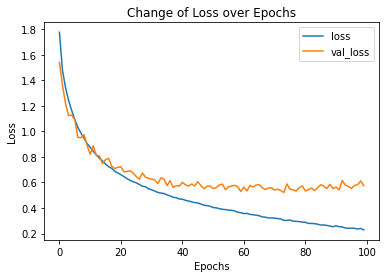

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Change of Loss over Epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

## Análise da métrica de desempenho (acurácia)
Vamos observar o desempenho (acurácia) da rede para os dados de treino e de validação.

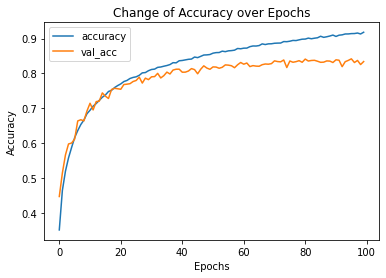

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.title('Change of Accuracy over Epochs')
plt.legend(['accuracy', 'val_acc'])
plt.show()

## Teste da rede neural treinada (fazendo predições)

Após o treinamento da rede, vamos realizar alguns testes com imagens que não fazem parte dos dados originais de treino e teste.

Cada imagem a ser testada deve ser redimensionada para o formato utilizado no treinamento da rede neural (32x32) e convertida para um array.

Carregamento das imagens testes

In [14]:
from google.colab import files
uploaded = files.upload()

Saving frog.jpg to frog.jpg


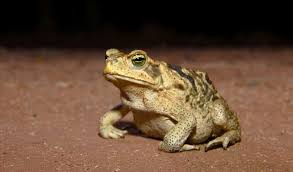

frog


In [15]:
import numpy as np
from keras.preprocessing import image
from IPython.display import display, Image

file_name = 'frog.jpg'
imagem_teste = image.load_img(file_name, target_size = (32, 32))
imagem_teste = image.img_to_array(imagem_teste)
imagem_teste = np.expand_dims(imagem_teste, axis = 0)
# prepara os pixels
imagem_teste = imagem_teste.astype('float32')
imagem_teste = imagem_teste/255.0
# predicao do modelo
predicao = np.argmax(model.predict(imagem_teste),axis=-1)
# lista de strings das classes  
classe = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# exibe a imagem teste             
display(Image(file_name)) 
print(classe[int(predicao)])                

## Referências:

*   https://www.kaggle.com/c/cifar-10/overview
*   https://keras.io/api/datasets/
